# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Описание данных:**

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

### Подключим необходимые библиотеки и настройки:

Импортируем библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

Создадим и применим функцию функцию, которая будет на вход принимать датафрейм, а на выходе будет выводить все необходимые характеристики поочередно применяя методы:

In [2]:
def data_info(dataframe):
    print('Выведем общую информацию по датафрейму:')
    display(dataframe.info())
    print('\nВыведем первые 10 строк:')
    display(dataframe.head(10))
    print('\nВыведем последние 10 строк:')
    display(dataframe.tail(10))
    print('\nПосмотрим пропуски:')
    display(dataframe.isnull().sum().sort_values(ascending=False))
    print('\nПосмотрим на описание датафрейма:')
    display(dataframe.describe())
    print('\nКоличество дубликатов:')
    display(dataframe.duplicated().sum())
    duplicate_list = []
    for i in dataframe[dataframe['id'].duplicated()]['id']:
        if i not in duplicate_list:
            duplicate_list.append(i)
    print('Неявные дупликаты в "id":', dataframe[dataframe['id'].duplicated()]['id'].values)
    print('\nПосмотрим на признаки:\n')
    num_columns, cat_columns = [], []
    for num, i in enumerate(dataframe.columns):
        if pd.api.types.is_numeric_dtype(dataframe[i]):
            print(f'{num+1}. {i} - числовой признак, уникальных значений: {len(dataframe[i].unique())}')
            num_columns.append(i)
        elif pd.api.types.is_object_dtype(dataframe[i]):
            print(f'{num+1}. {i} - категориальный признак, уникальных значений: {len(dataframe[i].unique())}')
            cat_columns.append(i)
    print(f'\nИтого:\nЧисловых признаков: {len(num_columns)}\nКатегориальных признаков: {len(cat_columns)}')
    print('\nПосмотрим на распределение признаков:')
    dataframe.hist(bins=50, figsize=(10, 10))
    plt.show()
    print('\nПосмотрим на корреляцию признаков:')
    corr = dataframe.corr()
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(corr, center=0, cmap='crest', square=True,
                linewidth=0.3, cbar_kws={'shrink': .8}, annot=True, mask=mask)
    plt.show()    

### Загрузим датафреймы и посмотрим на них:

Поскольку датфреймов у нас три, загрузим их циклом и поместим в список:

In [3]:
dataframes = []
for i in range(3):
    try:
        data = pd.read_csv(f'D:\\____geo_data_{i}.csv')
    except FileNotFoundError:
        data = pd.read_csv(f'https://____geo_data_{i}.csv')
    dataframes.append(data)
    
data1, data2, data3 = dataframes
data1.name, data2.name, data3.name = 'регион_1', 'регион_2', 'регион_3'

Поочередно выведем информацию о датафреймах:

'регион_1'

Выведем общую информацию по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Выведем первые 10 строк:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945



Выведем последние 10 строк:


,id,f0,f1,f2,product
99990,uQHju,-0.169592,0.988432,5.153578,121.253686
99991,5aJ79,-0.880711,0.173065,6.962537,152.614843
99992,vgK5D,0.637601,0.751503,2.918322,95.180855
99993,sOhIk,-0.176367,0.912145,5.241132,89.619662
99994,hWIah,1.562007,-0.311641,1.315442,50.092191
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246



Посмотрим пропуски:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Посмотрим на описание датафрейма:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Количество дубликатов:


0

Неявные дупликаты в "id": ['HZww2' 'bxg6G' 'A5aEY' 'QcMuo' '74z30' 'AGS9W' 'Tdehs' 'fiKDv' 'TtcGQ'
 'bsk9y']

Посмотрим на признаки:

1. id - категориальный признак, уникальных значений: 99990
2. f0 - числовой признак, уникальных значений: 100000
3. f1 - числовой признак, уникальных значений: 100000
4. f2 - числовой признак, уникальных значений: 100000
5. product - числовой признак, уникальных значений: 100000

Итого:
Числовых признаков: 4
Категориальных признаков: 1

Посмотрим на распределение признаков:


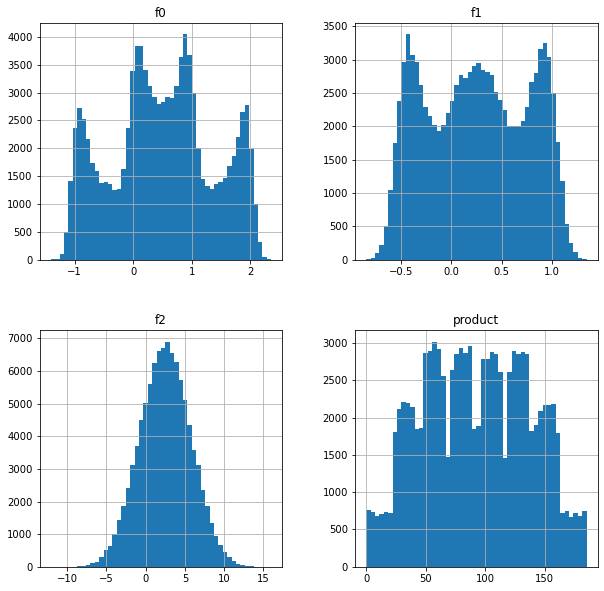


Посмотрим на корреляцию признаков:


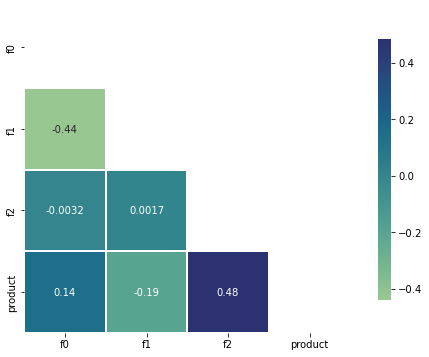

'регион_2'

Выведем общую информацию по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Выведем первые 10 строк:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408



Выведем последние 10 строк:


,id,f0,f1,f2,product
99990,6HSBo,4.280434,-1.692187,1.011469,26.953261
99991,obwpN,2.233158,-1.970310,1.004117,26.953261
99992,BYhdw,-2.150114,-13.278717,3.002298,84.038886
99993,FOKH6,-8.421251,-2.813906,4.997337,137.945408
99994,VfVub,-8.646179,-3.661656,-0.003027,3.179103
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103



Посмотрим пропуски:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Посмотрим на описание датафрейма:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Количество дубликатов:


0

Неявные дупликаты в "id": ['LHZR0' 'bfPNe' 'wt4Uk' '5ltQ6']

Посмотрим на признаки:

1. id - категориальный признак, уникальных значений: 99996
2. f0 - числовой признак, уникальных значений: 100000
3. f1 - числовой признак, уникальных значений: 100000
4. f2 - числовой признак, уникальных значений: 100000
5. product - числовой признак, уникальных значений: 12

Итого:
Числовых признаков: 4
Категориальных признаков: 1

Посмотрим на распределение признаков:


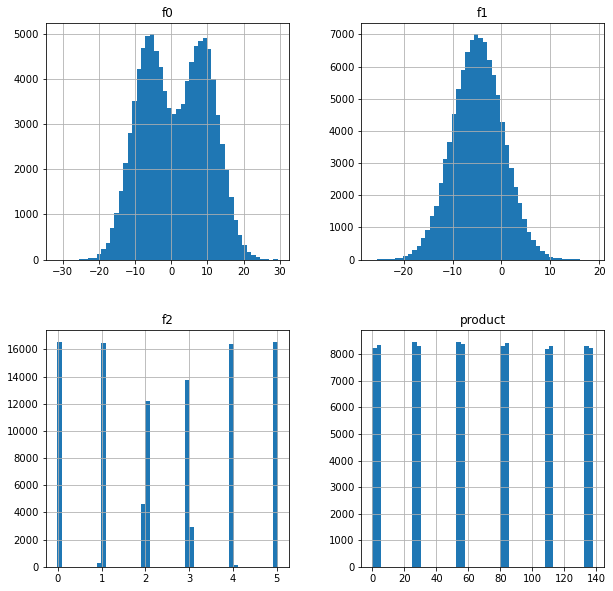


Посмотрим на корреляцию признаков:


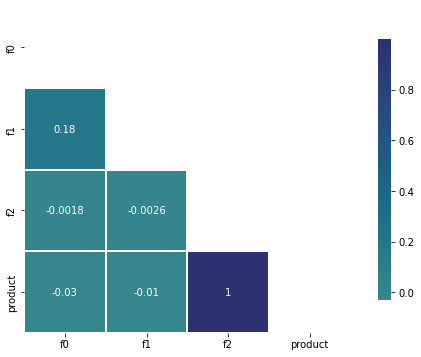

'регион_3'

Выведем общую информацию по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Выведем первые 10 строк:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532



Выведем последние 10 строк:


,id,f0,f1,f2,product
99990,QlYmx,-1.182179,2.127844,2.338479,78.502786
99991,AAcyW,1.570887,-2.430724,5.733563,83.577214
99992,yDrAl,-2.365583,0.148640,2.062216,151.374166
99993,uHI1Q,2.633658,1.873285,-0.498951,33.627420
99994,B2U80,-1.889398,0.851823,6.805412,96.866615
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767



Посмотрим пропуски:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Посмотрим на описание датафрейма:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



Количество дубликатов:


0

Неявные дупликаты в "id": ['xCHr8' 'VF7Jo' 'KUPhW' 'Vcm5J']

Посмотрим на признаки:

1. id - категориальный признак, уникальных значений: 99996
2. f0 - числовой признак, уникальных значений: 100000
3. f1 - числовой признак, уникальных значений: 100000
4. f2 - числовой признак, уникальных значений: 100000
5. product - числовой признак, уникальных значений: 100000

Итого:
Числовых признаков: 4
Категориальных признаков: 1

Посмотрим на распределение признаков:


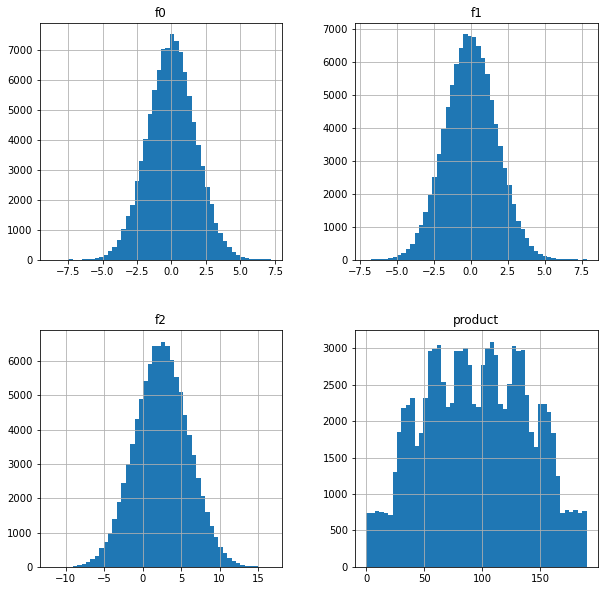


Посмотрим на корреляцию признаков:


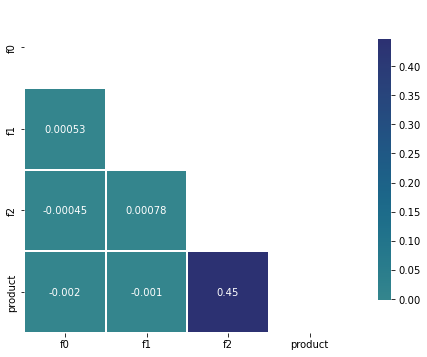

In [4]:
for data in dataframes:
    display(data.name)
    data_info(data)

### Предварительный вывод:

- Все три датафрейма имеют одинаковые структуры: 10000 строк и 5 столбцов.
- Пропуски и явные дубликаты во всех трех датафреймах отсутсвуют.
- В столцах "id" всех датафреймов присутвуют неуникальные значения, но для исследования он не пригодится, поэтому удалим его.
- Во втором датафрейме (data2) в признаке объёма запасов в скважине ("product") уникальных значений всего 12, отсюда и странное распределение на гистограмме. Но как либо интерпретировать мы это не можем потому, что данные в таблицах синтетические. Будем иметь это ввиду при работе с машинным обучением.
- В признаке f2 мы наблюдаем корреляцию с признаком "product" во всех датафреймах. Во втором датафрейме (data2) эта корреляция 100%, то есть прямая зависимость. Также будем об этом помнить.

**Удалим стобцы "id" из всех датафреймов и проверим:**

In [5]:
for data in dataframes:
    data.drop('id', axis=1, inplace=True)
    # Проверим:
    display(data.name)
    display(data.columns)

'регион_1'

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

'регион_2'

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

'регион_3'

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

**С подготовкой данных закончили, приступим к обучению и проверке модели:**

## Обучение и проверка модели

Создадим функцию, которая принимает датафрейм, разбивает его на на обучающую и валидационную выборки в соотношении 75:25, масштабирует признаки и возвращает предказания, таргет, и RMSE модели.

In [6]:
def split_and_train(data):
 
    features = data.drop('product', axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    lr = LinearRegression(normalize=False)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)
    average_product_pred = np.mean(predictions)
    average_product_real = np.mean(target_valid)
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    
    print('Cредний запас предсказанного сырья: {0:.2f}'.format(average_product_pred))
    print('Истинный средний запас сырья: {0:.2f}'.format(average_product_real))
    print('RMSE: {0:.2f}'.format(rmse))
    
    return (predictions, target_valid.reset_index(drop=True), rmse, average_product_pred, average_product_real)

In [7]:
display(data1.name)
predictions_1, target_1, rmse_1, avg_1, avg_real_1 = split_and_train(data1)
display(data2.name)
predictions_2, target_2, rmse_2, avg_2, avg_real_2 = split_and_train(data2)
display(data3.name)
predictions_3, target_3, rmse_3, avg_3, avg_real_3 = split_and_train(data3)

'регион_1'

Cредний запас предсказанного сырья: 92.59
Истинный средний запас сырья: 92.08
RMSE: 37.58


'регион_2'

Cредний запас предсказанного сырья: 68.73
Истинный средний запас сырья: 68.72
RMSE: 0.89


'регион_3'

Cредний запас предсказанного сырья: 94.97
Истинный средний запас сырья: 94.88
RMSE: 40.03


In [8]:
# Создадим таблицу для визуализации вывода:
model_result = pd.DataFrame({
    'Регион': [dataframes[0].name, dataframes[1].name, dataframes[2].name], 
    'RMSE': [rmse_1, rmse_2, rmse_3], 
    'Предсказанный средний запас сырья': [avg_1, avg_2, avg_3], 
    'Истинный средний запас сырья': [avg_real_1, avg_real_2, avg_real_3],
    
})

### Вывод:

Из полученых при исследовании модели данных, можем сделать вывод:
- Самый высокий средний запас предсказанного сырья и RMSE в третьем регионе.
- Судя по показателю RSME самым привлекательным кажется второй регион, но он сильно уступает остальным по запасам сырья.

In [9]:
display(model_result)

,Регион,RMSE,Предсказанный средний запас сырья,Истинный средний запас сырья
0,регион_1,37.579422,92.592568,92.078597
1,регион_2,0.893099,68.728547,68.723136
2,регион_3,40.029709,94.965046,94.884233


## Подготовка к расчёту прибыли

### Зададим переменные со значениями по заданию:

In [10]:
# При разведке региона исследуют 500 точек:
EXPLORATION_REG = 500

# из которых с помощью машинного обучения выбирают 200 лучших для разработки:
BEST_EXPLORATION_REG = 200

# Бюджет на разработку скважин в регионе:
DEVELOPMENT_BUDGET = 1e10

# При нынешних ценах один баррель сырья приносит 450 рублей дохода:
BARREL_REVENUE = 450

# Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей:
REVENUE_PER_UNIT = BARREL_REVENUE * 1000

# После оценки рисков мы оставим лишь те регионы, в которых вероятность убытков меньше 2.5%:
PROBABILITY_OF_LOSS = 2.5

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [11]:
break_even_volume = DEVELOPMENT_BUDGET/BEST_EXPLORATION_REG/REVENUE_PER_UNIT
print(f'Достаточный объём для безубыточной разработки новой скважины: {break_even_volume:.4f} тыс. баррелей.')

Достаточный объём для безубыточной разработки новой скважины: 111.1111 тыс. баррелей.


### Сравним полученный объём сырья со средним запасом в каждом регионе:

In [12]:
pd.DataFrame({
    'Регион': [dataframes[0].name, dataframes[1].name, dataframes[2].name], 
    'Истинный средний запас сырья': [avg_real_1, avg_real_2, avg_real_3], 
    'Необходимый объём сырья': [break_even_volume]*3,
    'Недостаток сырья': [avg_real_1 - break_even_volume,
                        avg_real_2 - break_even_volume,
                        avg_real_3 - break_even_volume,]
    
})

,Регион,Истинный средний запас сырья,Необходимый объём сырья,Недостаток сырья
0,регион_1,92.078597,111.111111,-19.032514
1,регион_2,68.723136,111.111111,-42.387975
2,регион_3,94.884233,111.111111,-16.226878


### Вывод:

Предсказанный объем сырья во всех регионах меньше достаточного для безубыточной разработки новой скважины.

## Расчёт прибыли и рисков 

### Посчитаем риски и прибыль для каждого региона:

Создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [13]:
def revenue(target, predicted, count):
    
    # Сбросим индексы,чтобы идентичные элементы не "множились" при вычислениях
    target = pd.Series(target).reset_index(drop=True)
    predicted = pd.Series(predicted).reset_index(drop=True)
    
    # Выберем скважины с максимальными значениями предсказаний:
    predicted_sorted = predicted.sort_values(ascending=False)
    # Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям:
    selected = target[predicted_sorted.index][:count]



    # КОД РЕВЬЮЕРА, debug
    if target.loc[predicted_sorted.index].shape[0] != predicted_sorted.shape[0]:
        print("Shape mismatch! Targets shape:", target.loc[predicted_sorted.index].shape)



    return (sum(selected) * REVENUE_PER_UNIT) - DEVELOPMENT_BUDGET

Напишем функцию, которая принимает таргет и предсказания, при помощи Bootstrap с 1000 выборок, находит распределение прибыли и возращает среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [14]:
def profit(target, prediction):
    random_state = np.random.RandomState(seed=12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(EXPLORATION_REG, replace = True, random_state = random_state)
        preds_subsample = prediction.loc[target_subsample.index]

        values.append(revenue(target_subsample, preds_subsample, BEST_EXPLORATION_REG))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = values[values < 0].count()/values.count()*100
    mean = values.mean()
    print('Средняя прибыль в регионе:', round(mean/10**6, 2), 'млн.руб')
    print('Доверительный интервал от', round(lower/10**6, 2),'млн.руб.', 'до', round(upper/10**6, 2),'млн.руб')
    print('Риск:', round(risk, 2), '%')
    values.hist(bins=30, figsize=(5, 5))
    # Отображаем границы доверительного интервала вертикальными линиями
    plt.axvline(lower, color='r', linestyle='--')
    plt.axvline(upper, color='r', linestyle='--')
    plt.title('Распределение прибыли')
    plt.xlabel('Прибыль')
    plt.ylabel('Скважины')
    plt.show()

'регион_1'

Средняя прибыль в регионе: 396.16 млн.руб
Доверительный интервал от -111.22 млн.руб. до 909.77 млн.руб
Риск: 6.9 %


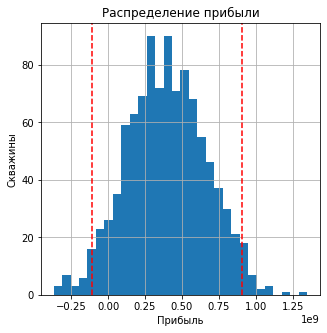

'регион_2'

Средняя прибыль в регионе: 456.05 млн.руб
Доверительный интервал от 33.82 млн.руб. до 852.29 млн.руб
Риск: 1.5 %


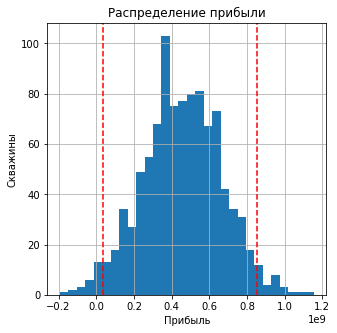

'регион_3'

Средняя прибыль в регионе: 404.4 млн.руб
Доверительный интервал от -163.35 млн.руб. до 950.36 млн.руб
Риск: 7.6 %


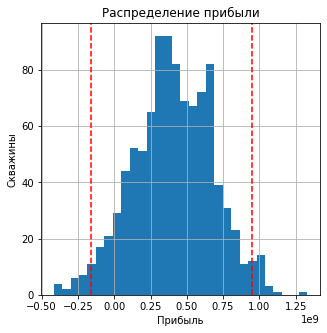

In [15]:
display(data1.name)
profit(target_1, predictions_1)
display(data2.name)
profit(target_2, predictions_2)
display(data3.name)
profit(target_3, predictions_3)

### Общий вывод:

**В этом проекте мы:**

- Подготовили данные.
- Обучили и проверили модели.
- Провели подготовку к расчёту прибыли
- Для всех ключевых значений создали константы Python
- Посчитали минимальное среднее количество продукта в месторождениях региона, достаточное для разработки.
- Написали функция расчёта прибыли.
- Посчитаны риски и прибыль.
- Провели процедуру Bootstrap

**На основе полученных данных пришли к выводу:**

- Самая высокая прогнозируемая средняя прибыль во втором регионе (456.05 млн.руб)
- Самые низкие риски во вторум регионе (1.5 %)
- Самый маленький доверительный интевал во втором регионе (от 33.82 млн.руб. до 852.29 млн.руб)

**Мы можем рекомендовать для разработки второй регион.**